In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from functools import partial  # Higher-order functions and operations on callable objects

In [74]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
input_range = np.linspace(-1, 1, 100, dtype=np.float32)
input_data = torch.tensor(input_range).reshape(1, -1).to(device).requires_grad_(True)
 
# Reference function
def target_function(x):
    return torch.sin(10 * x)

true_output = target_function(input_data).to(device)


In [75]:


# Xavier initialization function
def xavier_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

# Neural network definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, output_dim),
        )
        self.network.apply(xavier_init)

    def forward(self, x):
        return self.network(x)

In [89]:
# Initialize model
hidden_units = 100
model = NeuralNetwork(1, hidden_units, 1).to(device)
 
# Optimizer and loss function
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(input_data.T).T
    loss = ((predictions - true_output)**2).mean() #criterion(predictions, true_output)
    loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch + 1) % 50 == 1 or epoch + 1 == epochs:
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

def closure(model, optimizer,input_data,true_output):
    optimizer.zero_grad()
    predictions = model(input_data.T).T
    loss = ((predictions - true_output)**2).mean()
    loss.backward(retain_graph=True)
    global epoch
    epoch += 1
    if (epoch) % 50 == 1 or epoch + 1 == epochs:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
    
    return loss   
 
def train_lbfgs(model,input_data,true_output, num_iter=5_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

    closure_fn = partial(closure, model, optimizer, input_data, true_output)
    optimizer.step(closure_fn) 
 
train_lbfgs(model,input_data,true_output, num_iter=5_000)

Epoch: 1, Loss: 0.46090003848075867
Epoch: 51, Loss: 0.4606879651546478
Epoch: 101, Loss: 0.46057090163230896
Epoch: 151, Loss: 0.4604080617427826
Epoch: 201, Loss: 0.45842060446739197
Epoch: 251, Loss: 0.4508321285247803
Epoch: 301, Loss: 0.4504513442516327
Epoch: 351, Loss: 0.45033133029937744
Epoch: 401, Loss: 0.45036283135414124
Epoch: 451, Loss: 0.44989103078842163
Epoch: 501, Loss: 0.44518977403640747
Epoch: 551, Loss: 0.21240650117397308
Epoch: 601, Loss: 0.010414300486445427
Epoch: 651, Loss: 0.00028730405028909445
Epoch: 701, Loss: 7.616026414325461e-05
Epoch: 751, Loss: 0.00019009220704901963
Epoch: 801, Loss: 5.165812399354763e-05
Epoch: 851, Loss: 3.15728502755519e-05
Epoch: 901, Loss: 2.60988344962243e-05
Epoch: 951, Loss: 3.193129305145703e-05
Epoch: 1001, Loss: 0.00036819453816860914
Epoch: 1051, Loss: 3.797837780439295e-05
Epoch: 1101, Loss: 1.4483563973044511e-05
Epoch: 1151, Loss: 1.2484601938922424e-05
Epoch: 1201, Loss: 0.0008257481968030334
Epoch: 1251, Loss: 1.495

In [90]:
# Predictions after training
model.eval()
with torch.no_grad():
    predicted_output = model(input_data.T).T

In [91]:
error = torch.norm(true_output - predicted_output, p=2)
print(f"Error: {error.item()}")

Error: 0.005815235432237387


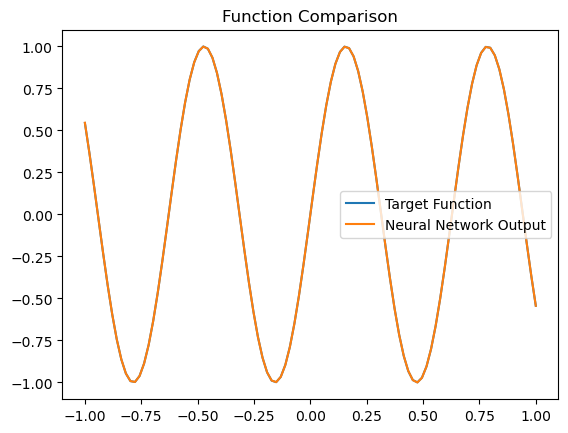

In [92]:
# Plot results
plt.plot(input_data.cpu().detach().numpy().flatten(), true_output.cpu().detach().numpy().flatten(), label="Target Function")
plt.plot(input_data.cpu().detach().numpy().flatten(), predicted_output.cpu().detach().numpy().flatten(), label="Neural Network Output")
plt.legend()
plt.title("Function Comparison")
plt.show()

In [93]:
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    Computes the derivative of a given tensor 'dy' with respect to another tensor 'x',
    up to a specified order.

    Args:
        dy (torch.Tensor): The tensor whose derivative is to be computed.
        x (torch.Tensor): The tensor with respect to which the derivative is to be computed.
        order (int, optional): The order of the derivative to compute. Defaults to 1, which
                               means a first-order derivative. Higher orders result in higher-order
                               derivatives.

    Returns:
        torch.Tensor: The computed derivative of 'dy' with respect to 'x', of the specified order.
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy  

In [94]:
predicted_output_grad  = derivative(model(input_data.T).T, input_data, 1)[0]
target_output_grad = derivative(target_function(input_data), input_data, 1)[0]

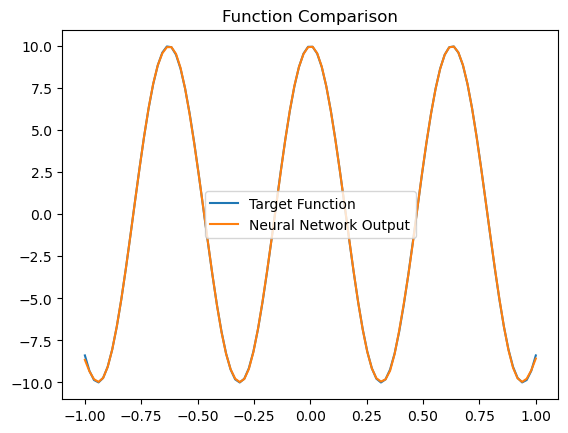

In [95]:
# Plot results
plt.plot(input_data.cpu().detach().numpy().flatten(), target_output_grad.cpu().detach().numpy().flatten(), label="Target Function")
plt.plot(input_data.cpu().detach().numpy().flatten(), predicted_output_grad.cpu().detach().numpy().flatten(), label="Neural Network Output")
plt.legend()
plt.title("Function Comparison")
plt.show()

In [96]:
predicted_output_grad  = derivative(model(input_data.T).T, input_data, 2)[0]
target_output_grad = derivative(target_function(input_data), input_data, 2)[0]

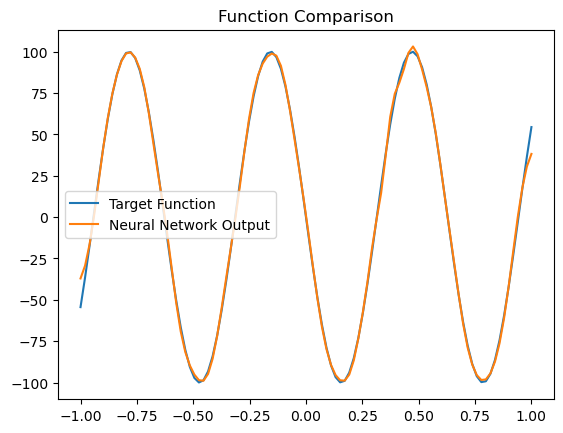

In [97]:
# Plot results
plt.plot(input_data.cpu().detach().numpy().flatten(), target_output_grad.cpu().detach().numpy().flatten(), label="Target Function")
plt.plot(input_data.cpu().detach().numpy().flatten(), predicted_output_grad.cpu().detach().numpy().flatten(), label="Neural Network Output")
plt.legend()
plt.title("Function Comparison")
plt.show()